<a href="https://colab.research.google.com/github/9terry-student/pytorch/blob/main/8_Loss%26Optimizer%26Backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
# 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

In [118]:
# 문장->토큰화->토큰ID
sentence="I went to the hospital"
tokens=sentence.lower().split()
print("tokens:",tokens)

vocab={w:i for i,w in enumerate(tokens)}
print("vocab:",vocab)

token_ids=torch.tensor([[vocab[w] for w in tokens]])    # (B=1,S=5)
print("token_ids:",token_ids)

tokens: ['i', 'went', 'to', 'the', 'hospital']
vocab: {'i': 0, 'went': 1, 'to': 2, 'the': 3, 'hospital': 4}
token_ids: tensor([[0, 1, 2, 3, 4]])


In [119]:
# Embedding
B,S=token_ids.shape
D=8

embedding=nn.Embedding(len(vocab),D)
x=embedding(token_ids)
print("embedding output shape:",x.shape)

embedding output shape: torch.Size([1, 5, 8])


In [120]:
# Positional Encoding
def positional_encoding(seq_len,embed_dim):
  pe=torch.zeros(seq_len,embed_dim)
  for pos in range(seq_len):
    for i in range(0,embed_dim,2):
      pe[pos,i]=math.sin(pos/(10000**(i/embed_dim)))
      pe[pos,i+1]=math.cos(pos/(10000**(i/embed_dim)))
  return pe

pe=positional_encoding(S,D).unsqueeze(0)    # (1,S,D)
x=x+pe    # 위치 정보 추가
print("after positional encoding:",x.shape)

after positional encoding: torch.Size([1, 5, 8])


In [121]:
# Mask 생성 코드
def causal_mask(seq_len):
  return torch.tril(torch.ones(seq_len,seq_len))

print(causal_mask(5))

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


In [122]:
# Masked Multi-Head Attention
class MaskedMultiHeadAttention(nn.Module):
  def __init__(self,embed_dim,num_heads):
    super().__init__()
    assert embed_dim%num_heads==0, "D는 head 수로 나누어 떨어져야 함"
    self.num_heads=num_heads
    self.head_dim=embed_dim//num_heads

    # Q,K,V를 전체 D에서 한 번에 만들기
    self.q=nn.Linear(embed_dim,embed_dim)
    self.k=nn.Linear(embed_dim,embed_dim)
    self.v=nn.Linear(embed_dim,embed_dim)

    self.out=nn.Linear(embed_dim,embed_dim)

  def forward(self,x):
    B,S,D=x.shape

    # Q,K,V shape: (B,S,D)
    Q=self.q(x)
    K=self.k(x)
    V=self.v(x)

    # Multi-Head로 나누기: (B,head,S,head_dim)
    Q=Q.view(B,S,self.num_heads,self.head_dim).transpose(1,2)
    K=K.view(B,S,self.num_heads,self.head_dim).transpose(1,2)
    V=V.view(B,S,self.num_heads,self.head_dim).transpose(1,2)

    # Attention 계산
    scores=Q@K.transpose(-2,-1)/(self.head_dim**0.5)

    # Mask
    mask=causal_mask(S).to(x.device)
    scores=scores.masked_fill(mask==0,-1e9)

    weights=F.softmax(scores,dim=-1)
    out=weights@V   # (B,head,S,head_dim)

    # 다시 합치기
    out=out.transpose(1,2).contiguous().view(B,S,D)
    out=self.out(out)
    return out,weights

In [123]:
# MiniEncoder Layer
class MiniEncoder(nn.Module):
  def __init__(self,embed_dim,num_heads):
    super().__init__()
    self.mha=MaskedMultiHeadAttention(embed_dim,num_heads)
    self.norm1=nn.LayerNorm(embed_dim)
    self.norm2=nn.LayerNorm(embed_dim)

    self.ff=nn.Sequential(
        nn.Linear(embed_dim,4*embed_dim),
        nn.ReLU(),
        nn.Linear(4*embed_dim,embed_dim)
    )
  def forward(self,x):
    # Multi-Head+Residual+LayerNorm
    attn_out,weights=self.mha(x)
    x=self.norm1(x+attn_out)

    # FeedForward+Residual+LayerNorm
    ff_out=self.ff(x)
    x=self.norm2(x+ff_out)

    return x,weights

In [124]:
# Decoder Layer
class DecoderLayer(nn.Module):
  def __init__(self,embed_dim,num_heads):
    super().__init__()
    self.self_attn=MaskedMultiHeadAttention(embed_dim,num_heads)
    self.norm1=nn.LayerNorm(embed_dim)
    self.norm2=nn.LayerNorm(embed_dim)

    self.ff=nn.Sequential(
        nn.Linear(embed_dim,embed_dim*4),
        nn.ReLU(),
        nn.Linear(embed_dim*4,embed_dim)
    )
  def forward(self,x):
    attn_out,attn_weights=self.self_attn(x)
    x=self.norm1(x+attn_out)

    ff_out=self.ff(x)
    x=self.norm2(x+ff_out)

    return x,attn_weights

In [125]:
# Multi-Layer Encoder
class EncoderStack(nn.Module):
  def __init__(self,embed_dim,num_heads,num_layers):
    super().__init__()
    self.layers=nn.ModuleList([
        MiniEncoder(embed_dim,num_heads)
        for _ in range(num_layers)
    ])

  def forward(self,x):
    all_attn=[]
    for layer in self.layers:
      x,attn=layer(x)
      all_attn.append(attn)
    return x,all_attn

In [126]:
# 학습용 입력 / 정답
token_ids=torch.tensor([[vocab[w] for w in tokens]])    # (1,S)

x_ids=token_ids[:,:-1]    # 입력
y_ids=token_ids[:,1:]   # 정답

print("x_ids:",x_ids)
print("y_ids:",y_ids)

x_ids: tensor([[0, 1, 2, 3]])
y_ids: tensor([[1, 2, 3, 4]])


In [127]:
# Embedding + PE
D=16
embedding=nn.Embedding(len(vocab),D)

x=embedding(x_ids)    # (1,S-1,D)
pe=positional_encoding(x.shape[1],D).unsqueeze(0)
x=x+pe

In [128]:
# Decoder + 출력 헤드
decoder=DecoderLayer(embed_dim=D,num_heads=2)
lm_head=nn.Linear(D,len(vocab))

In [129]:
# Loss / Optimizer
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(
    list(embedding.parameters())+
    list(decoder.parameters())+
    list(lm_head.parameters()),
    lr=0.01
)

In [130]:
# Training loop
for step in range(300):
  x=embedding(x_ids)
  x=x+positional_encoding(x.shape[1],D).unsqueeze(0)

  dec_out,attn=decoder(x)
  logits=lm_head(dec_out)

  loss=loss_fn(
      logits.view(-1,len(vocab)),
      y_ids.view(-1)
  )

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if step%50==0:
    print(f"step {step}, loss {loss.item():.4f}")

step 0, loss 1.5266
step 50, loss 0.0040
step 100, loss 0.0018
step 150, loss 0.0011
step 200, loss 0.0007
step 250, loss 0.0005


In [131]:
# Prediction 확인
inv_vocab={i:w for w,i in vocab.items()}    # vocab id -> token

pred=logits.argmax(dim=-1)[0]

print("prediction:")
for i in pred:
  print(inv_vocab[i.item()],end=" ")

prediction:
went to the hospital 

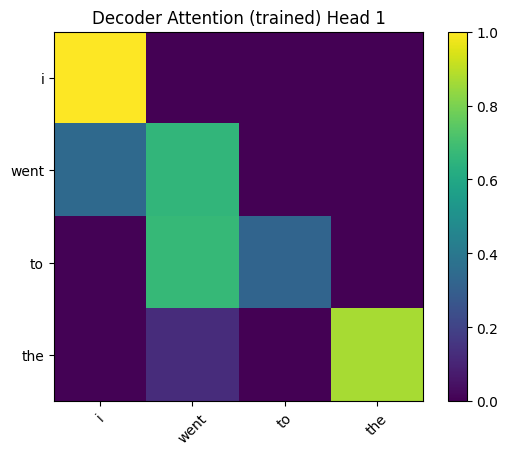

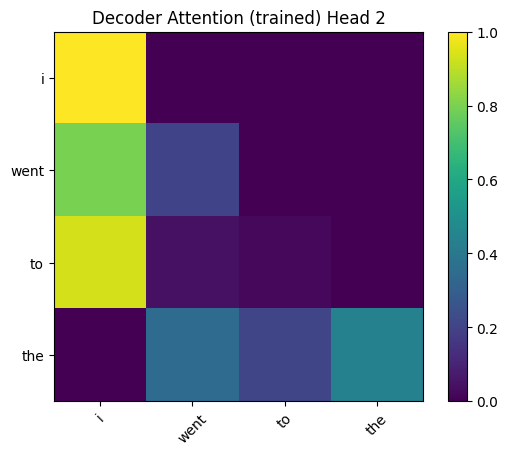

In [132]:
# 학습 후 Attention 히트맵
dec_out,attn=decoder(x)

for head in range(attn.shape[1]):
  plt.figure()
  plt.imshow(attn[0,head].detach().numpy())
  plt.xticks(range(x.shape[1]),tokens[:-1],rotation=45)
  plt.yticks(range(x.shape[1]),tokens[:-1])
  plt.colorbar()
  plt.title(f"Decoder Attention (trained) Head {head+1}")
  plt.show()